# **GoDaddy - MICROBUSINESS DENSITY ESTIMATION**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


1. **row_id** - An ID code for the row.
2. **cfips** - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
3. **county_name** - The written name of the county.
4. **state_name** - The name of the state.
5. **first_day_of_month** - The date of the first day of the month.
6. **microbusiness_density** - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
7. **active** - The raw count of microbusinesses in the county. Not provided for the test set.

In [4]:
df = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv")
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.008,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.885,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.056,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993,1243


In [5]:
df.shape

(122265, 7)

In [6]:
df.describe()

,cfips,microbusiness_density,active
count,122265.000,122265.000,122265.000
mean,30376.038,3.818,6442.858
std,15143.509,4.991,33040.012
min,1001.000,0.000,0.000
25%,18177.000,1.639,145.000
50%,29173.000,2.587,488.000
75%,45077.000,4.519,2124.000
max,56045.000,284.340,1167744.000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


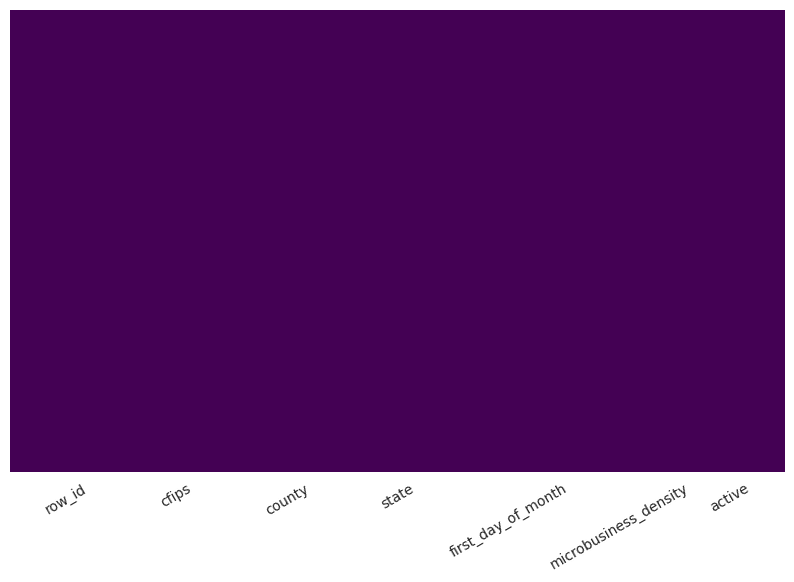

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');
plt.xticks(rotation=30)
plt.show()

In [9]:
df.cfips.nunique()

3135

In [10]:
df.county.value_counts()

Washington County        1170
Jefferson County          975
Franklin County           936
Lincoln County            897
Jackson County            897
                         ... 
Androscoggin County        39
Winn Parish                39
West Feliciana Parish      39
West Carroll Parish        39
Weston County              39
Name: county, Length: 1871, dtype: int64

In [11]:
df.county.nunique()

1871

In [12]:
df.state.value_counts()

Texas                   9906
Georgia                 6201
Virginia                5070
Kentucky                4680
Missouri                4485
Kansas                  4095
Illinois                3978
North Carolina          3900
Iowa                    3861
Tennessee               3705
Nebraska                3588
Indiana                 3588
Ohio                    3432
Minnesota               3393
Michigan                3237
Mississippi             3198
Oklahoma                3003
Arkansas                2925
Wisconsin               2808
Pennsylvania            2613
Alabama                 2613
Florida                 2613
South Dakota            2535
Colorado                2496
Louisiana               2496
New York                2418
California              2262
Montana                 2184
West Virginia           2145
North Dakota            2067
South Carolina          1794
Idaho                   1716
Washington              1521
Oregon                  1404
New Mexico    

In [13]:
df.state.nunique()

51

In [14]:
df.first_day_of_month.value_counts()

2019-08-01    3135
2022-01-01    3135
2021-06-01    3135
2021-07-01    3135
2021-08-01    3135
2021-09-01    3135
2021-10-01    3135
2021-11-01    3135
2021-12-01    3135
2022-02-01    3135
2021-04-01    3135
2022-03-01    3135
2022-04-01    3135
2022-05-01    3135
2022-06-01    3135
2022-07-01    3135
2022-08-01    3135
2022-09-01    3135
2021-05-01    3135
2021-03-01    3135
2019-09-01    3135
2020-05-01    3135
2019-10-01    3135
2019-11-01    3135
2019-12-01    3135
2020-01-01    3135
2020-02-01    3135
2020-03-01    3135
2020-04-01    3135
2020-06-01    3135
2021-02-01    3135
2020-07-01    3135
2020-08-01    3135
2020-09-01    3135
2020-10-01    3135
2020-11-01    3135
2020-12-01    3135
2021-01-01    3135
2022-10-01    3135
Name: first_day_of_month, dtype: int64

In [15]:
df.first_day_of_month.nunique()

39

In [16]:
df.duplicated().sum()

0

In [17]:
df_rt = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv")
df_rt

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.443,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.471,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.258,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.251,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247,247
...,...,...,...,...,...,...,...
6265,56041_2022-12-01,56041,Uinta County,Wyoming,2022-12-01,4.051,588
6266,56043_2022-11-01,56043,Washakie County,Wyoming,2022-11-01,3.143,190
6267,56043_2022-12-01,56043,Washakie County,Wyoming,2022-12-01,3.060,185
6268,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785,100


In [18]:
df = pd.concat([df,df_rt],ignore_index=True)
df = df.sort_values([ "cfips", "row_id"]).reset_index(drop=True)
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.008,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.885,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.056,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993,1243
...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785,100
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785,100
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785,100
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785,100


In [19]:
df[["year", "month","day"]] = df.first_day_of_month.str.split("-", expand=True)
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,day
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.008,1249,2019,08,01
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.885,1198,2019,09,01
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.056,1269,2019,10,01
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993,1243,2019,11,01
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993,1243,2019,12,01
...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785,100,2022,08,01
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785,100,2022,09,01
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785,100,2022,10,01
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785,100,2022,11,01


In [20]:
df['first_day_of_month'] = pd.to_datetime(df["first_day_of_month"])

In [21]:
# df = df[["row_id", "cfips", "county", "state", "microbusiness_density","active", "year", "month"]]
# df

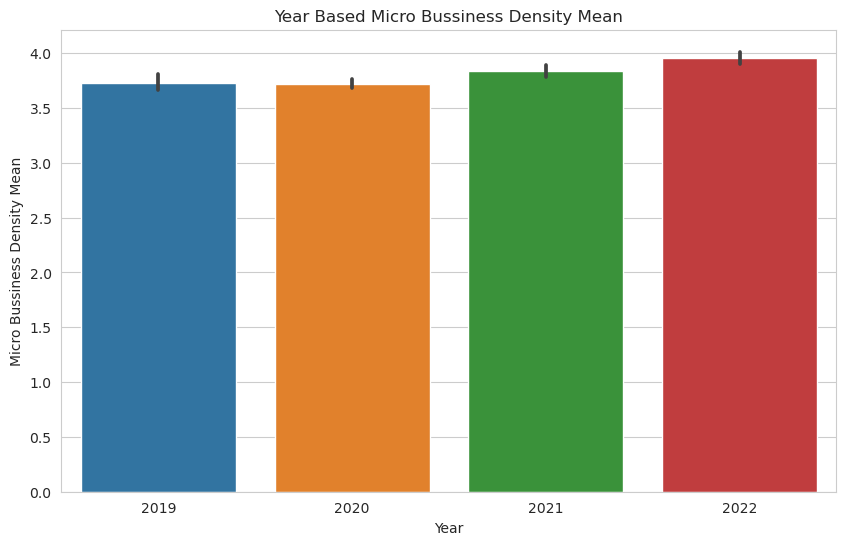

In [22]:
sns.barplot(x='year', y="microbusiness_density", data=df)
plt.title('Year Based Micro Bussiness Density Mean')
plt.xlabel('Year')
plt.ylabel('Micro Bussiness Density Mean')
plt.show()

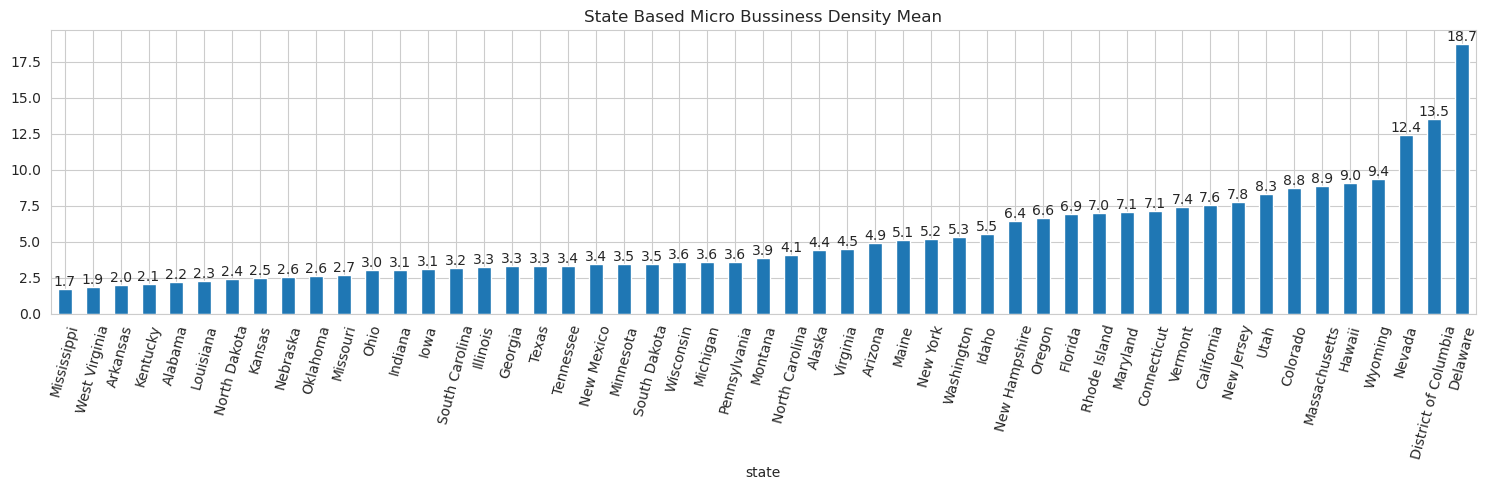

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
df.groupby("state").microbusiness_density.mean().sort_values().plot(kind="bar")
plt.title('State Based Micro Bussiness Density Mean')
plt.xticks(rotation=75)

for c in ax.containers:
    labels = [str(round(v.get_height().round(1), 2)) if v.get_height() >= 1 else '' for v in c]
    ax.bar_label(c,
                 labels = labels)

plt.tight_layout()
plt.show()

In [24]:
df.groupby("state").microbusiness_density.mean().sort_values()

state
Mississippi             1.705
West Virginia           1.860
Arkansas                2.000
Kentucky                2.079
Alabama                 2.232
Louisiana               2.255
North Dakota            2.424
Kansas                  2.468
Nebraska                2.575
Oklahoma                2.615
Missouri                2.728
Ohio                    3.041
Indiana                 3.071
Iowa                    3.128
South Carolina          3.151
Illinois                3.271
Georgia                 3.302
Texas                   3.323
Tennessee               3.351
New Mexico              3.444
Minnesota               3.473
South Dakota            3.479
Wisconsin               3.563
Michigan                3.604
Pennsylvania            3.607
Montana                 3.907
North Carolina          4.058
Alaska                  4.428
Virginia                4.466
Arizona                 4.939
Maine                   5.111
New York                5.227
Washington              5.333
Idah

In [25]:
df[df["state"]=="Delaware"].microbusiness_density

12874    4.996
12875    5.032
12876    5.098
12877    5.125
12878    5.086
         ...  
12992   58.198
12993   58.926
12994   59.590
12995   60.994
12996   59.089
Name: microbusiness_density, Length: 123, dtype: float64

In [26]:
df.groupby(["year","month"]).microbusiness_density.mean()

year  month
2019  08      3.750
      09      3.697
      10      3.778
      11      3.723
      12      3.717
2020  01      3.689
      02      3.636
      03      3.649
      04      3.700
      05      3.716
      06      3.723
      07      3.743
      08      3.764
      09      3.772
      10      3.770
      11      3.759
      12      3.745
2021  01      3.711
      02      3.785
      03      3.813
      04      3.836
      05      3.835
      06      3.835
      07      3.845
      08      3.860
      09      3.861
      10      3.877
      11      3.911
      12      3.925
2022  01      3.902
      02      3.918
      03      3.956
      04      3.959
      05      3.942
      06      3.903
      07      3.966
      08      3.954
      09      3.959
      10      4.007
      11      4.015
      12      4.037
Name: microbusiness_density, dtype: float64

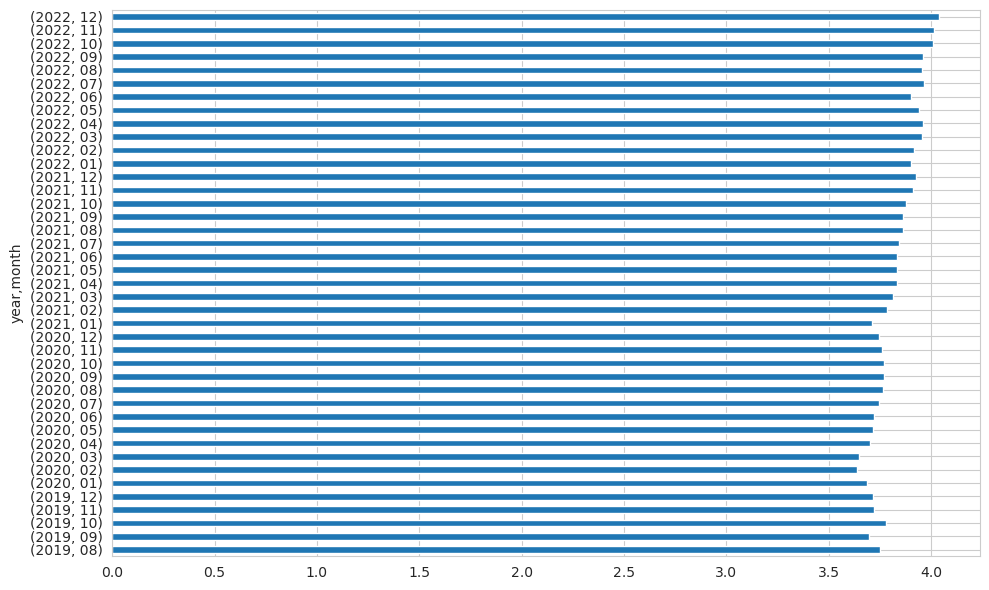

In [27]:
df.groupby(["year","month"]).microbusiness_density.mean().plot(kind="barh")
plt.tight_layout()
plt.show()

In [28]:
df.groupby("state").active.max().sort_values()

state
West Virginia              5318
Mississippi                7026
North Dakota               9175
Montana                   11369
Vermont                   14627
Alaska                    16530
Arkansas                  18784
Iowa                      21601
Maine                     21679
Louisiana                 23961
Rhode Island              27296
New Hampshire             32271
Alabama                   33154
New Mexico                33594
Wisconsin                 40711
Idaho                     43738
Kentucky                  44644
South Carolina            46463
Hawaii                    47334
South Dakota              49893
Indiana                   50424
Nebraska                  53465
Wyoming                   56975
Kansas                    64200
Tennessee                 69691
Ohio                      70187
Missouri                  74229
Oregon                    78412
District of Columbia      81002
Utah                      96425
Minnesota                108057
Vi

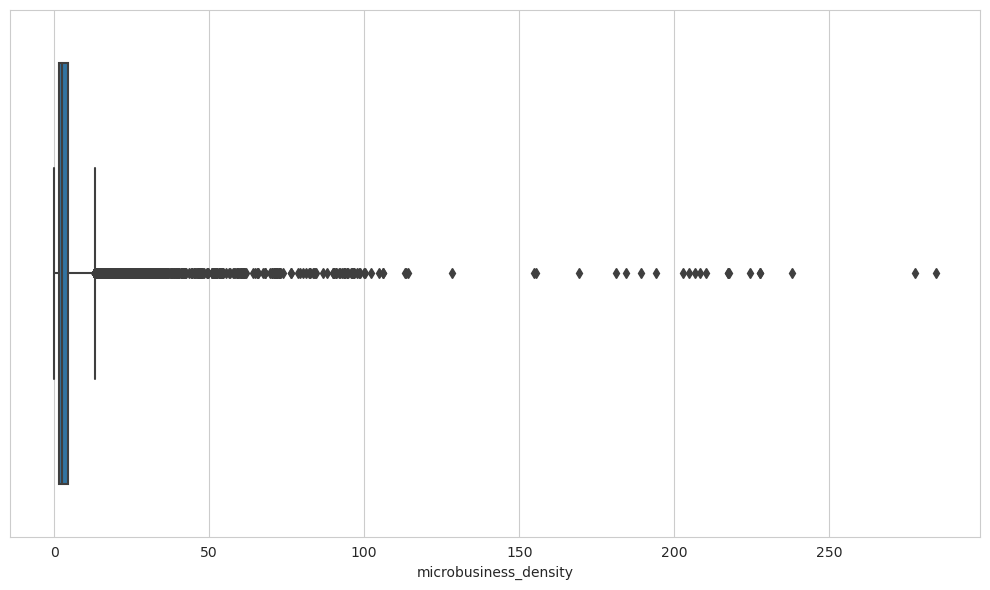

In [29]:
sns.boxplot(df, x="microbusiness_density", whis=3)
plt.tight_layout()
plt.show()

In [30]:
df[df["microbusiness_density"] > 200]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,day
72185,32510_2021-09-01,32510,Carson City,Nevada,2021-09-01,202.790,88323,2021,09,01
72186,32510_2021-10-01,32510,Carson City,Nevada,2021-10-01,204.766,89184,2021,10,01
72187,32510_2021-11-01,32510,Carson City,Nevada,2021-11-01,206.808,90073,2021,11,01
72188,32510_2021-12-01,32510,Carson City,Nevada,2021-12-01,210.047,91484,2021,12,01
72189,32510_2022-01-01,32510,Carson City,Nevada,2022-01-01,208.227,91545,2022,01,01
72190,32510_2022-02-01,32510,Carson City,Nevada,2022-02-01,217.587,95660,2022,02,01
72191,32510_2022-03-01,32510,Carson City,Nevada,2022-03-01,217.255,95514,2022,03,01
72192,32510_2022-04-01,32510,Carson City,Nevada,2022-04-01,217.141,95464,2022,04,01
72193,32510_2022-05-01,32510,Carson City,Nevada,2022-05-01,224.538,98716,2022,05,01
99220,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.536,31245,2019,08,01


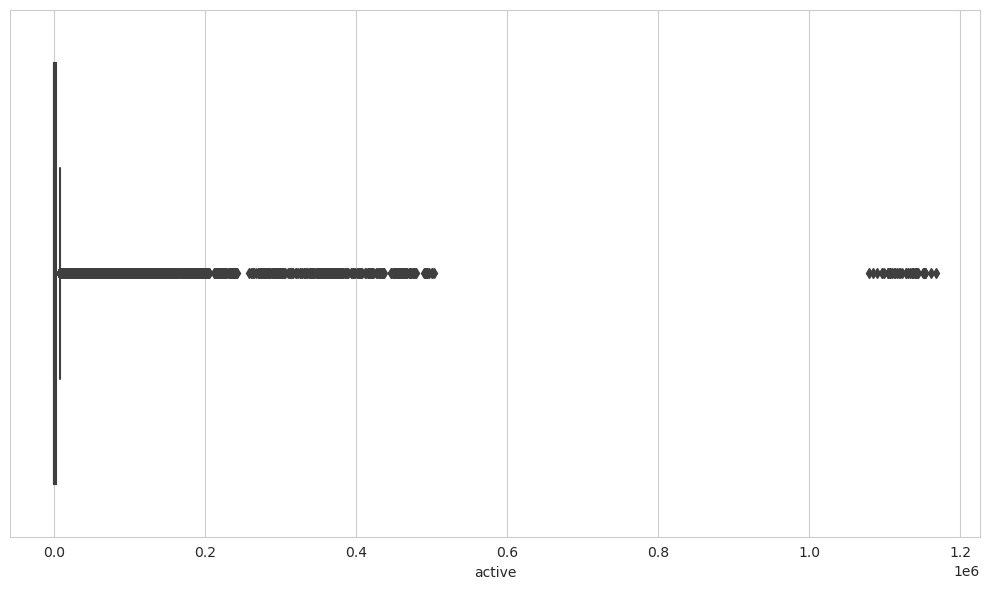

In [31]:
sns.boxplot(df, x="active",whis=3)
plt.tight_layout()
plt.show()

In [32]:
df_cs = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
df_cs

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.600,78.900,80.600,82.700,85.500,1001,14.500,15.900,16.100,16.700,16.400,2.100,2.000,2.300,2.300,2.100,1.300,1.100,0.700,0.600,1.100,55317,58786.000,58731,57982.000,62660.000
1,74.500,78.100,81.800,85.100,87.900,1003,20.400,20.700,21.000,20.200,20.600,3.200,3.400,3.700,3.400,3.500,1.400,1.300,1.400,1.000,1.300,52562,55962.000,58320,61756.000,64346.000
2,57.200,60.400,60.500,64.600,64.600,1005,7.600,7.800,7.600,7.300,6.700,2.700,2.500,2.700,2.600,2.600,0.500,0.300,0.800,1.100,0.800,33368,34186.000,32525,34990.000,36422.000
3,62.000,66.100,69.200,76.100,74.600,1007,8.100,7.600,6.500,7.400,7.900,1.000,1.400,1.500,1.600,1.100,1.200,1.400,1.600,1.700,2.100,43404,45340.000,47542,51721.000,54277.000
4,65.800,68.500,73.000,79.600,81.000,1009,8.700,8.100,8.600,8.900,9.300,4.500,4.400,4.500,4.400,4.500,1.300,1.400,0.900,1.100,0.900,47412,48695.000,49358,48922.000,52830.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,82.200,82.400,84.000,86.700,88.400,56037,15.300,15.200,14.800,13.700,12.400,5.000,5.300,4.700,5.200,5.500,0.600,0.600,1.000,0.900,1.000,71083,73008.000,74843,73384.000,76668.000
3138,83.500,85.900,87.100,89.100,90.500,56039,37.700,37.800,38.900,37.200,38.300,10.800,11.200,11.800,11.400,11.100,0.700,1.200,1.400,1.500,2.000,80049,83831.000,84678,87053.000,94498.000
3139,83.800,88.200,89.500,91.400,90.600,56041,11.900,10.500,11.100,12.600,12.300,2.900,3.100,2.900,2.900,2.900,1.200,1.200,1.400,1.700,0.900,54672,58235.000,63403,72458.000,75106.000
3140,76.400,78.300,78.200,82.800,85.400,56043,15.400,15.000,15.400,15.000,17.200,2.300,1.400,1.600,2.200,1.000,1.300,1.000,0.900,0.900,1.100,51362,53426.000,54158,57306.000,62271.000


* **pct_bb_[year]** - The percentage of households in the county with access to broadband of any type. 
Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.
cfips - The CFIPS code.

* **pct_college_[year]** - The percent of the population in the county over age 25 with a 4-year college degree. 
Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

* **pct_foreign_born_[year]** - The percent of the population in the county born outside of the United States. 
Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

* **pct_it_workers_[year]** - The percent of the workforce in the county employed in information related industries. 
Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.

* **median_hh_inc_[year]** - The median household income in the county. 
Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

In [33]:
df['population']  = 100 * df['active'] / df['microbusiness_density']
df['population'] = df.groupby('cfips')['population'].ffill()
df['population'] = df['population'].round(0).astype(int)

In [34]:
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128535 entries, 0 to 128534
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 128535 non-null  object        
 1   cfips                  128535 non-null  int64         
 2   county                 128535 non-null  object        
 3   state                  128535 non-null  object        
 4   first_day_of_month     128535 non-null  datetime64[ns]
 5   microbusiness_density  128535 non-null  float64       
 6   active                 128535 non-null  int64         
 7   year                   128535 non-null  int64         
 8   month                  128535 non-null  int64         
 9   day                    128535 non-null  int64         
 10  population             128535 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 10.8+ MB


In [36]:
df_cs17 = df_cs[["cfips", "pct_bb_2017", "pct_college_2017", "pct_foreign_born_2017", "pct_it_workers_2017", "median_hh_inc_2017"]]
df_cs18 = df_cs[["cfips", "pct_bb_2018", "pct_college_2018", "pct_foreign_born_2018", "pct_it_workers_2018", "median_hh_inc_2018"]]
df_cs19 = df_cs[["cfips", "pct_bb_2019", "pct_college_2019", "pct_foreign_born_2019", "pct_it_workers_2019", "median_hh_inc_2019"]]
df_cs20 = df_cs[["cfips", "pct_bb_2020", "pct_college_2020", "pct_foreign_born_2020", "pct_it_workers_2020", "median_hh_inc_2020"]]
df_cs21 = df_cs[["cfips", "pct_bb_2021", "pct_college_2021", "pct_foreign_born_2021", "pct_it_workers_2021", "median_hh_inc_2021"]]
df_cs17["year"] = 2017 + 2
df_cs18["year"] = 2018 + 2
df_cs19["year"] = 2019 + 2
df_cs20["year"] = 2020 + 2
df_cs21["year"] = 2021 + 2

In [37]:
df_cs17.sample(3)

,cfips,pct_bb_2017,pct_college_2017,pct_foreign_born_2017,pct_it_workers_2017,median_hh_inc_2017,year
2219,41023,73.100,11.500,2.400,1.100,44826,2019
1216,24510,69.500,15.900,8.000,2.100,46641,2019
2204,40147,73.800,18.500,4.200,1.900,50388,2019


In [38]:
df_cs21.sample(3)

,cfips,pct_bb_2021,pct_college_2021,pct_foreign_born_2021,pct_it_workers_2021,median_hh_inc_2021,year
2041,38103,81.100,19.000,0.600,1.400,58932.000,2023
635,17081,83.200,11.700,1.900,1.100,54692.000,2023
523,13277,70.800,8.300,5.300,1.200,46245.000,2023


In [39]:
df_m = df.copy()

In [40]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128535 entries, 0 to 128534
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 128535 non-null  object        
 1   cfips                  128535 non-null  int64         
 2   county                 128535 non-null  object        
 3   state                  128535 non-null  object        
 4   first_day_of_month     128535 non-null  datetime64[ns]
 5   microbusiness_density  128535 non-null  float64       
 6   active                 128535 non-null  int64         
 7   year                   128535 non-null  int64         
 8   month                  128535 non-null  int64         
 9   day                    128535 non-null  int64         
 10  population             128535 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 10.8+ MB


In [41]:
df_m = df_m.merge(df_cs17, on=["cfips", "year"], how="left", sort=False)
df_m = df_m.merge(df_cs18, on=["cfips", "year"], how="left", sort=False)
df_m = df_m.merge(df_cs19, on=["cfips", "year"], how="left", sort=False)
df_m = df_m.merge(df_cs20, on=["cfips", "year"], how="left", sort=False)

In [42]:
df_m["broadband"] = df_m.pct_bb_2017.fillna(df_m.pct_bb_2018).fillna(df_m.pct_bb_2019).fillna(df_m.pct_bb_2020)
df_m["college"] = df_m.pct_college_2017.fillna(df_m.pct_college_2018).fillna(df_m.pct_college_2019).fillna(df_m.pct_college_2020)
df_m["foreign_born"] = df_m.pct_foreign_born_2017.fillna(df_m.pct_foreign_born_2018).fillna(df_m.pct_foreign_born_2019).fillna(df_m.pct_foreign_born_2020)
df_m["IT"] = df_m.pct_it_workers_2017.fillna(df_m.pct_it_workers_2018).fillna(df_m.pct_it_workers_2019).fillna(df_m.pct_it_workers_2020)
df_m["household_income"] = df_m.median_hh_inc_2017.fillna(df_m.median_hh_inc_2018).fillna(df_m.median_hh_inc_2019).fillna(df_m.median_hh_inc_2020)

In [43]:
df_m = df_m[['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'population', 'month', 'year',
       'broadband', 'college', 'foreign_born', 'IT', 'household_income']]

In [44]:
df_m.sample(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,population,month,year,broadband,college,foreign_born,IT,household_income
118306,51145_2021-05-01,51145,Powhatan County,Virginia,2021-05-01,4.511,1062,23543,5,2021,89.500,20.900,2.200,2.100,89090.000
69220,31073_2020-08-01,31073,Gosper County,Nebraska,2020-08-01,1.475,24,1627,8,2020,78.800,18.600,1.100,0.500,62545.000
24571,17013_2020-08-01,17013,Calhoun County,Illinois,2020-08-01,1.589,61,3839,8,2020,66.800,7.600,0.800,0.000,54392.000
46770,22059_2022-02-01,22059,LaSalle Parish,Louisiana,2022-02-01,0.911,104,11410,2,2022,78.400,12.400,1.600,0.300,51141.000
30635,18105_2020-04-01,18105,Monroe County,Indiana,2020-04-01,5.163,6319,122382,4,2020,82.800,23.900,8.300,2.600,47075.000
33482,19059_2021-10-01,19059,Dickinson County,Iowa,2021-10-01,7.091,985,13891,10,2021,82.500,24.600,1.500,1.200,59969.000
93101,42059_2022-03-01,42059,Greene County,Pennsylvania,2022-03-01,1.816,534,29402,3,2022,80.700,11.800,0.800,0.700,55993.000
107006,48181_2022-09-01,48181,Grayson County,Texas,2022-09-01,5.756,5862,101835,9,2022,79.000,14.100,6.000,1.400,58296.000
115521,51003_2021-08-01,51003,Albemarle County,Virginia,2021-08-01,6.206,5317,85682,8,2021,85.300,28.500,10.400,1.500,79880.000
85008,39067_2020-11-01,39067,Harrison County,Ohio,2020-11-01,1.605,194,12085,11,2020,70.400,6.300,0.700,1.400,48462.000


In [45]:
df_m.shape

(128535, 15)

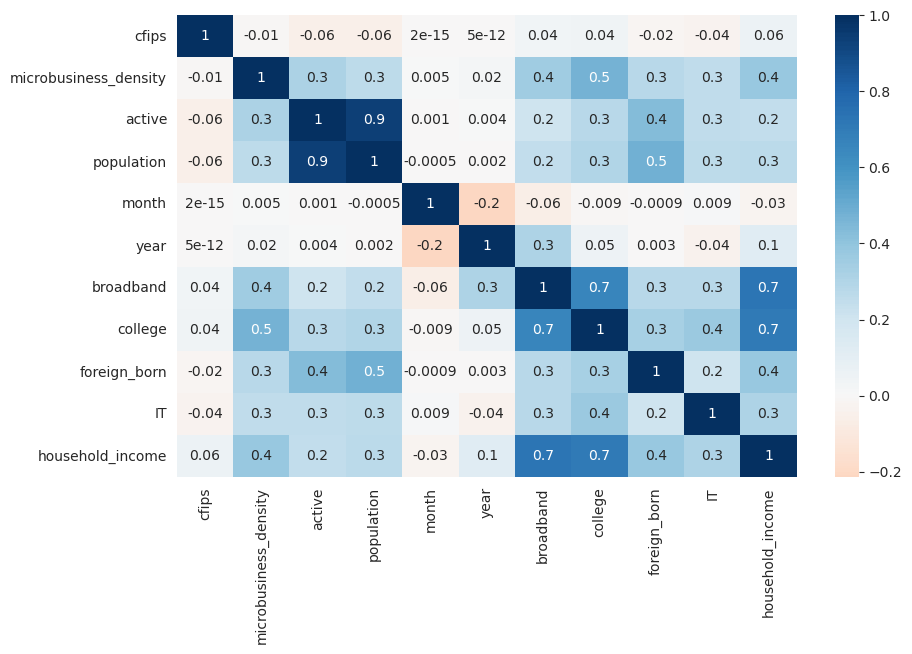

In [46]:
sns.heatmap(df_m.corr(), cmap="RdBu", fmt=".1g", center=0, annot=True);

In [47]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [48]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [49]:
def train_val(model, X_train, y_train, X_test, y_test):

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    scores = {
        "train": {
            "R2": r2_score(y_train, y_train_pred),
            "mae": mean_absolute_error(y_train, y_train_pred),
            "mse": mean_squared_error(y_train, y_train_pred),
            "rmse": np.sqrt(mean_squared_error(y_train, y_train_pred)),
            "smap": smape(y_train, y_train_pred)
        },
        "test": {
            "R2": r2_score(y_test, y_pred),
            "mae": mean_absolute_error(y_test, y_pred),
            "mse": mean_squared_error(y_test, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
            "smap": smape(y_test, y_pred)
        }
    }

    return pd.DataFrame(scores)

In [50]:
X = df_m.drop(["microbusiness_density", "row_id", "first_day_of_month"], axis=1)
y = df_m.microbusiness_density 
cat = X.select_dtypes("object").columns
cat

Index(['county', 'state'], dtype='object')

In [51]:
from sklearn.model_selection import train_test_split

# Using Train-Test Spilt for model
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=101)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (102828, 12)
Train target shape   :  (102828,)
Test features shape  :  (25707, 12)
Test target shape    :  (25707,)


In [52]:
df_m["first_day_of_month"].value_counts().sort_index()

2019-08-01    3135
2019-09-01    3135
2019-10-01    3135
2019-11-01    3135
2019-12-01    3135
2020-01-01    3135
2020-02-01    3135
2020-03-01    3135
2020-04-01    3135
2020-05-01    3135
2020-06-01    3135
2020-07-01    3135
2020-08-01    3135
2020-09-01    3135
2020-10-01    3135
2020-11-01    3135
2020-12-01    3135
2021-01-01    3135
2021-02-01    3135
2021-03-01    3135
2021-04-01    3135
2021-05-01    3135
2021-06-01    3135
2021-07-01    3135
2021-08-01    3135
2021-09-01    3135
2021-10-01    3135
2021-11-01    3135
2021-12-01    3135
2022-01-01    3135
2022-02-01    3135
2022-03-01    3135
2022-04-01    3135
2022-05-01    3135
2022-06-01    3135
2022-07-01    3135
2022-08-01    3135
2022-09-01    3135
2022-10-01    3135
2022-11-01    3135
2022-12-01    3135
Name: first_day_of_month, dtype: int64

In [53]:
df_m["first_day_of_month"].nunique()

41

In [54]:
# # 2 - Selecting last (eight) months as Test set (approximately 0.20 of dataset)
# X_train = X[X["first_day_of_month"] < "2022-05-01"]
# y_train = df_m.microbusiness_density[df_m["first_day_of_month"] < "2022-05-01"]

# X_test = X[X["first_day_of_month"] >= "2022-05-01"]
# y_test = df_m.microbusiness_density[df_m["first_day_of_month"] >= "2022-05-01"]

# print("Train features shape : ", X_train.shape)
# print("Train target shape   : ", y_train.shape)
# print("Test features shape  : ", X_test.shape)
# print("Test target shape    : ", y_test.shape)

In [55]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

In [56]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat), remainder='passthrough')

In [57]:
# Model_xgb =  xgb.XGBRegressor(
#         objective='reg:pseudohubererror',
#         #objective='reg:squarederror',
#         tree_method="gpu_hist",
#         colsample_bytree=0.50,
#         learning_rate=0.02,
#         max_bin=4096,
#         max_leaves = 24,
#         n_estimators=5000,
#         subsample=0.50,
#         n_jobs=-1,
#         eval_metric='mae',
#     )

In [58]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# operations = [("OrdinalEncoder", column_trans),
#               ("XGB_model", Model_xgb)]

# pipe_model = Pipeline(steps=operations)

# pipe_model.fit(X_train, y_train)

In [59]:
# df_pred = df_m.copy()
# df_pred["pred"] = pipe_model.predict(df_pred)

In [60]:
# train_val(pipe_model, X_train, y_train, X_test, y_test)

In [61]:
#  print('XGB SMAPE:', smape(df_pred['microbusiness_density'], df_pred['pred']))

In [62]:
# print('XGB VSMAPE:', vsmape(df_pred['microbusiness_density'], df_pred['pred']))

In [63]:
# param_grid = {
#     "XGB_model__colsample_bytree": [1],
#     "XGB_model__learning_rate": [0.045],
#     "XGB_model__max_bin": [2048],
#     "XGB_model__max_depth": [6],    
#     "XGB_model__max_leaves": [16],    
#     "XGB_model__n_estimators": [120000,150000],
#     "XGB_model__subsample": [0.75]
# }

In [64]:
# from sklearn.model_selection import GridSearchCV
# operations = [("OrdinalEncoder", column_trans),
#               ("XGB_model",
#                XGBRegressor(random_state=101, 
#                             objective='reg:pseudohubererror', 
#                             tree_method="gpu_hist", 
#                             #verbosity=2
#                            )
#               )
#              ]

# model = Pipeline(steps=operations)

# grid_model = GridSearchCV(estimator=model,
#                           param_grid=param_grid,
#                           scoring='neg_mean_absolute_error',
#                           n_jobs=-1,
#                           cv=5,
#                           return_train_score=True)

In [65]:
# grid_model.fit(X_train, y_train)

In [66]:
# grid_model.best_params_

In [67]:
# grid_model.best_score_

In [68]:
# train_val(grid_model, X_train, y_train, X_test, y_test)

**Calculating the SMAPE value according to model performance**

In [69]:
# operations = [("OrdinalEncoder", column_trans),
#               ("XGB_model",
#                XGBRegressor(random_state=101, 
#                             objective='reg:pseudohubererror', 
#                             tree_method="gpu_hist", 
#                             #verbosity=2
#                            )
#               )
#              ]

# new_model = Pipeline(steps=operations)
# new_model.set_params(**grid_model.best_params_)
# new_model.fit(X_train, y_train)

# df_pred["pred"] = new_model.predict(df_pred)
# print('XGB GRIDSEARCH SMAPE:', smape(df_pred['microbusiness_density'], df_pred['pred']))

**BEST MODEL**

**Building Model with Best Hyperparameter**

In [ ]:
est = 1150000
best_model =  xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        tree_method="gpu_hist",
        colsample_bytree=1,
        learning_rate=0.045,
        max_bin=2048,
        max_leaves = 16,
        n_estimators=est,
        subsample=0.75,
        n_jobs=-1
    )

operations = [("OrdinalEncoder", column_trans),
              ("XGB_model", best_model)
              ]

best_pipe_model = Pipeline(steps=operations)
best_pipe_model.fit(X_train, y_train)

In [ ]:
df_pred = df_m.copy()
df_pred["pred"] = best_pipe_model.predict(df_pred)

In [ ]:
train_val(best_pipe_model, X_train, y_train, X_test, y_test)

In [ ]:
print('FINAL SMAPE:', smape(df_pred['microbusiness_density'], df_pred['pred']))

In [ ]:
df_pred.shape

**Feature Importance**

In [ ]:
# features = list(X_train.select_dtypes("object").columns) + list(X_train.select_dtypes("number").columns)
# features

In [ ]:
# XGB_fea_imp = pd.DataFrame(data=best_pipe_model["XGB_model"].feature_importances_, 
#                            index=features, columns=["Feature Importance"]).sort_values("Feature Importance", ascending=False)
# XGB_fea_imp

In [ ]:
# ax = sns.barplot(x=XGB_fea_imp["Feature Importance"], y=XGB_fea_imp.index)
# ax.bar_label(ax.containers[0], fmt="%.3f")
# plt.title("Feature Importance for XGBoost")
# plt.show()

In [ ]:
# df_pred = df_m.copy()
# df_pred["pred"] = final_pipe_model.predict(df_pred)

In [ ]:
#train_val(final_pipe_model, X_train, y_train, X_test, y_test)

In [ ]:
#print('FINAL SMAPE:', smape(df_pred['microbusiness_density'], df_pred['pred']))

**Model Export**

In [ ]:
# import joblib
# joblib.dump(final_pipe_model, open('final_pipe_model.pkl', 'wb'))
# final_pipe_model_g6 = joblib.load(open('final_pipe_model.pkl', 'rb'))

In [ ]:
# final_pipe_model_g6

# TEST SET MICROBUSINESS DENSITY PREDICTION

In [ ]:
df_test = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv")
df_test

In [ ]:
df_test[["year", "month","day"]] = df_test.first_day_of_month.str.split("-", expand=True)
df_test['first_day_of_month'] = pd.to_datetime(df_test["first_day_of_month"])
df_test["year"] = df_test["year"].astype(int)
df_test["month"] = df_test["month"].astype(int)
df_test["day"] = df_test["day"].astype(int)
df_test = df_test.sort_values([ "cfips", "row_id"]).reset_index(drop=True)

In [ ]:
df_test = pd.concat([df_pred[(df_pred['year']==2022) & (df_pred['month']>=11)], df_test[df_test['year']==2023]], ignore_index=True)

In [ ]:
df_test.shape

In [ ]:
df_test.head(5)

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test[df_test['year']==2023].shape

In [ ]:
df_test = df_test.merge(df_cs20, on=["cfips", "year"], how="left", sort=False)
df_test = df_test.merge(df_cs21, on=["cfips", "year"], how="left", sort=False)

In [ ]:
df_test.shape

In [ ]:
df_test["broadband"] = df_test.pct_bb_2020.fillna(df_test.pct_bb_2021)
df_test["college"] = df_test.pct_college_2020.fillna(df_test.pct_college_2021)
df_test["foreign_born"] = df_test.pct_foreign_born_2020.fillna(df_test.pct_foreign_born_2021)
df_test["IT"] = df_test.pct_it_workers_2020.fillna(df_test.pct_it_workers_2021)
df_test["household_income"] = df_test.median_hh_inc_2020.fillna(df_test.median_hh_inc_2021)

In [ ]:
df_test

In [ ]:
# columns selection
df_test = df_test[['row_id', 'cfips', 'county', 'state', 'first_day_of_month', 'month', 'year',
       'broadband', 'college', 'foreign_born', 'IT', 'household_income', 'microbusiness_density', 'active', 'population',]]

In [ ]:
df_test.columns

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test[['county', "state"]] = df_test.groupby('cfips')['county', "state"].ffill()
df_test['household_income'] = df_test.groupby(['cfips', "year", "month"])["household_income"].ffill().ffill()

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test.population

In [ ]:
df_test["population"].fillna(round(( df_test["population"][0]*0.05) + (df_test["population"][0]), 0), inplace=True)

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test['active'] = df_m.groupby('cfips')['active'].transform('mean')

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test.duplicated().sum()

In [ ]:
df_test.shape

In [ ]:
df_test.first_day_of_month.value_counts()

**Month by Month Test Data Microbusiness Density Data Creation**

In [ ]:
X = df_test.drop(["row_id", "first_day_of_month", "microbusiness_density"], axis=1)

In [ ]:
df_test["pred"] = final_pipe_model.predict(X)

In [ ]:
df_test

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test["microbusiness_density"] = df_test["microbusiness_density"].fillna(df_test["pred"])

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test.duplicated().sum()

In [ ]:
df_test[df_test["pred"].isnull()].head(10)

## Calculation of Final SMAPE

In [ ]:
X = df_test.drop(["pred", "row_id", "first_day_of_month","microbusiness_density"], axis=1)
y = df_test.microbusiness_density
cat = X.select_dtypes("object").columns
print(cat)

ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat), remainder='passthrough')

test_model =  xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        tree_method="gpu_hist",
        colsample_bytree=1,
        learning_rate=0.045,
        max_bin=2048,
        max_leaves = 16,
        n_estimators=est,
        subsample=0.75,
        n_jobs=-1
    )

operations = [("OrdinalEncoder", column_trans),
              ("XGB_model", test_model)
              ]

test_pipe_model = Pipeline(steps=operations)
test_pipe_model.fit(X, y)

df_test["pred2"] = test_pipe_model.predict(X)

print('FINAL SMAPE:', smape(df_test['microbusiness_density'], df_test['pred2']))

In [ ]:
sample_sub = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv")
sample_sub

In [ ]:
df_test

In [ ]:
submission = df_test[["row_id", "microbusiness_density"]]

In [ ]:
submission.to_csv("submission.csv" , index = False)